In [1]:
import json
import requests
import seaborn as sb
import datetime
import pandas as pd
import numpy as np
api = "https://api.jikan.moe/v4/"

# Set up jikan API

In [2]:
def sendRequest(payload):
	url = api+payload
	response = requests.get(url)
	return json.loads(response.text)
	
def getSeasonalAnime(season, year):
	payload='seasons/{0}/{1}'.format(year,season)
	t = sendRequest(payload)
	with open('sample.json', 'w') as outfile:
		outfile.write(json.dumps(t, indent=2))
	vals = ['score','type','episodes','title_english']
	data = []
	for x in t.get('data'):
		anime = []
		for y in vals:
			anime.append(x.get(y))
		genres = [g.get('name') for g in x.get('genres')]
		anime.append(genres)
		print(anime)
		data.append(anime)
	return data

def getSpecificAnime(id):
	payload='anime/{}'.format(id)
	t = sendRequest(payload)
	vals = ['type','source','episodes','score']
	data = [t.get('data').get(x) for x in vals]
	genres = [x.get('name') for x in t.get('data').get('genres')]
	data.append(genres)
	return data

In [3]:
t = getSeasonalAnime('fall','2022')

[None, 'TV', None, 'Chainsaw Man', ['Action', 'Adventure']]
[None, 'TV', None, 'Mob Psycho 100 III', ['Action', 'Comedy', 'Supernatural']]
[None, 'TV', None, 'My Hero Academia Season 6', ['Action']]
[None, 'TV', 13, None, ['Action', 'Comedy']]
[None, 'TV', None, 'Bleach: Thousand-Year Blood War', ['Action', 'Adventure', 'Fantasy']]
[None, 'TV', None, 'To Your Eternity Season 2', ['Adventure', 'Drama', 'Supernatural']]
[None, 'TV', None, 'Uzaki-chan Wants to Hang Out! Double', ['Comedy', 'Ecchi']]
[None, 'TV', None, 'Blue Lock', ['Sports']]
[None, 'TV', None, 'The Eminence in Shadow', ['Action', 'Comedy', 'Fantasy']]
[None, 'TV', None, 'Welcome to Demon School! Iruma-kun Season 3', ['Comedy', 'Fantasy', 'Supernatural']]
[None, 'TV', 8, None, ['Action', 'Sci-Fi', 'Slice of Life']]
[None, 'TV', 46, 'Urusei Yatsura', ['Comedy', 'Romance', 'Sci-Fi']]
[None, 'TV', None, 'Golden Kamuy Season 4', ['Action', 'Adventure']]
[None, 'TV', None, None, ['Action', 'Fantasy']]
[None, 'TV', None, None, 

In [4]:
df = pd.DataFrame(t, columns=['score','type','episodes','EnglishTitle','genres'])
df.head()

,score,type,episodes,EnglishTitle,genres
0,None,TV,NaN,Chainsaw Man,"[Action, Adventure]"
1,None,TV,NaN,Mob Psycho 100 III,"[Action, Comedy, Supernatural]"
2,None,TV,NaN,My Hero Academia Season 6,[Action]
3,None,TV,13.0,None,"[Action, Comedy]"
4,None,TV,NaN,Bleach: Thousand-Year Blood War,"[Action, Adventure, Fantasy]"


In [5]:
animeDf = pd.read_csv('anime.csv')

# Some preprocessing for names and premiered date

In [6]:
def setPremiered(id):
	premiered = animeDf[animeDf.MAL_ID == id]['Premiered'].values[0]
	if premiered is np.NaN or premiered == "Unknown":
		premiered = animeDf[animeDf.MAL_ID == id]['Aired'].values[0]
		if premiered is np.NaN or premiered == "Unknown":
			premiered = np.NaN
	return premiered
def getAnimeName(id):
	name = animeDf[animeDf.MAL_ID == id]['English name'].values[0]
	if name is np.nan or name == "Unknown":
		name = animeDf[animeDf.MAL_ID == id]['Name'].values[0]
	return name

animeDf.Premiered = animeDf.MAL_ID.apply(lambda x: setPremiered(x))
animeDf['eng_name'] = animeDf.MAL_ID.apply(lambda x :getAnimeName(x) )
animeDf = animeDf[['Score','Ranked','Genres','eng_name','Type','Episodes','Source','Studios','Premiered']]
animeDf = animeDf[animeDf.Score != 'Unknown']
animeDf = animeDf[animeDf.Ranked!= 'Unknown']
animeDf = animeDf[animeDf.Episodes != 'Unknown']
animeDf = animeDf[animeDf.Premiered != np.NaN]

animeDf.Score = animeDf.Score.apply(lambda x: float(x))
animeDf.Ranked = animeDf.Ranked.apply(lambda x: float(x))
animeDf.Episodes = animeDf.Episodes.apply(lambda x: int(x))

# Formatting available seasons to `Fall 2021` style
## a lot of inconsistent dates. Really should be Fall/Winter/Spring/Summer [year]

In [7]:
animeDf.Premiered.sample(10)

4092                     Dec 21, 1996
11762                     Jun 2, 2018
16547                     May 4, 2019
9150     Jun 25, 2014 to Nov 26, 2014
11461                     Feb 4, 2016
237                       Summer 2003
479                      Jul 29, 1989
12744    Feb 27, 2017 to Mar 13, 2017
9006     Jul 25, 2014 to Dec 24, 2014
16503    Jan 17, 2020 to Apr 10, 2020
Name: Premiered, dtype: object

In [8]:
import datetime
import re
days = {('Jan','Feb','Mar'): 'Winter',('Apr','May','Jun'): 'Spring',('Jul','Aug','Sep'): 'Summer', ('Oct','Nov','Dec'): 'Fall'}
working_monty = {}
for k, v in days.items():
	for key in k:
		working_monty[key] = v

def fixDateValue(val):
	daysFormat = re.compile(r"^[a-zA-Z]{3}\s\d+,\s\d{4}$")
	noDaysFormat = re.compile(r"^[a-zA-Z]{3},\s\d{4}")
	yearFormat = re.compile(r"^\d{4}$")
	monFormat = re.compile(r"^[a-zA-Z]{3},\s\d{4}$")
	if pd.isnull(val):
		val = np.NaN
	elif daysFormat.search(val):
		m = val.split(' ')[0]
		season = working_monty.get(m)
		val = str(season + " " + val.split(' ')[2].strip())
	elif yearFormat.search(val):
		y = pd.Series(data=['Winter','Summer','Spring','Fall'])
		month = y.sample(1).values[0]
		val = month + " " +str(val).strip()
	elif monFormat.search(val):
		m = val.split(',')[0]
		month = working_monty.get(m)
		val = month + " " + val.split(' ')[1].strip()
	elif noDaysFormat.search(val):
		m = val.split(' ')[0]
		m = m.replace(',','')
		month = working_monty.get(m)
		val = month + " " + val.split(' ')[1].strip()
	elif "to" in val:
		try:
			m = val.split("to")[0]
			m = m.split(' ')[0]
			m.replace(',','')
			season = working_monty.get(m)
			year = val.split(' ')[2].strip()
			val = str(season + " " + year)
		except:
			try:
				m = val.split("to")[0]
				y = pd.Series(data=['Winter','Summer','Spring','Fall'])
				month = y.sample(1).values[0]
				val = month +" "+ str(m).strip()
			except:
				print(val, "idk man")
	return val

# t=animeDf.Premiered[animeDf.index == 8413].values[0]
# print(t)
# fixDateValue(t)
animeDf['SeasonYear']= animeDf.Premiered.map(lambda x: fixDateValue(x))
animeDf.head()

,Score,Ranked,Genres,eng_name,Type,Episodes,Source,Studios,Premiered,SeasonYear
0,8.78,28.0,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Original,Sunrise,Spring 1998,Spring 1998
1,8.39,159.0,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Original,Bones,"Sep 1, 2001",Summer 2001
2,8.24,266.0,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,26,Manga,Madhouse,Spring 1998,Spring 1998
3,7.27,2481.0,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,TV,26,Original,Sunrise,Summer 2002,Summer 2002
4,6.98,3710.0,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,52,Manga,Toei Animation,Fall 2004,Fall 2004


# Pull studios with more than 50 shows and drop any unknown 

In [9]:
s = animeDf.Studios.value_counts()
studioDf = animeDf[animeDf.Studios.isin(s.index[s.gt(50)])]
studioDf = studioDf[studioDf.Studios != 'Unknown']
studioDf.shape

(4818, 10)

,Score,Ranked,Genres,eng_name,Type,Episodes,Source,Studios,Premiered,SeasonYear
0,8.78,28.0,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Original,Sunrise,Spring 1998,Spring 1998
1,8.39,159.0,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Original,Bones,"Sep 1, 2001",Summer 2001
2,8.24,266.0,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,26,Manga,Madhouse,Spring 1998,Spring 1998
3,7.27,2481.0,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,TV,26,Original,Sunrise,Summer 2002,Summer 2002
4,6.98,3710.0,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,52,Manga,Toei Animation,Fall 2004,Fall 2004


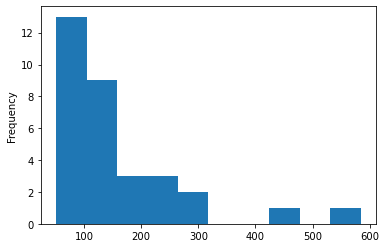

In [10]:
studioDf.Studios.value_counts().plot.hist()
studioDf.head()

### Lets see how many studios there are with more than 50 shows

In [11]:
studioDf.Studios.value_counts()

Toei Animation          584
Sunrise                 441
Madhouse                314
J.C.Staff               314
Production I.G          246
Studio Deen             242
Studio Pierrot          218
TMS Entertainment       209
A-1 Pictures            185
OLM                     184
Nippon Animation        146
Bones                   123
Gonzo                   118
Shaft                   117
Tatsunoko Production    115
Shin-Ei Animation       114
Xebec                   111
Kyoto Animation         110
AIC                     109
SILVER LINK.             85
Brain's Base             85
Satelight                76
Doga Kobo                73
ufotable                 61
Zexcs                    60
Production Reed          59
Studio 4°C               57
feel.                    54
Lerche                   53
Gainax                   52
DLE                      52
Arms                     51
Name: Studios, dtype: int64

## Separate out all the genres

In [12]:
def getGenreDf(df):
	l = df.Genres.to_numpy()
	l= [x.split(',') for x in l]
	uniqueGenres = []
	for x in l:
		for y in x:
			y.strip()
			if y not in uniqueGenres:
				uniqueGenres.append(y)
	uniqueGenres = np.array(uniqueGenres)
	uniqueGenres = [x.strip() for x in uniqueGenres]
	uniqueGenres = np.unique(uniqueGenres)
	genreCol = df.Genres
	index = df.index
	t = []
	for x in genreCol:
		ohe = np.zeros(len(uniqueGenres))
		genres = x.split(',')
		genres = [y.strip() for y in genres]
		for y in genres:
			index = np.where(uniqueGenres == y)
			ohe[index[0][0]] = 1
		t.append(ohe)
	#t = pd.Series(t, name='Genres', index=animeDf.index)
	genresDf = pd.DataFrame(t, columns=uniqueGenres, index=df.index)
	# genresDf.drop('Unknown',axis=1, inplace=True)
	return genresDf
gdf = getGenreDf(studioDf)
studioDf.drop('Genres',axis=1, inplace=True)
studioDf = studioDf.join(gdf)

In [13]:
studioDf.dropna(inplace=True)
studioDf['Season'] = studioDf.SeasonYear.map(lambda x: x.split(' ')[0])
studioDf['Year'] = studioDf.SeasonYear.map(lambda x: x.split(' ')[1])

# Time for some graphs

##### Quick function to pull all data for one studio out of the data frame

In [14]:
import matplotlib.pyplot as plt
def getStudio(studioName):
	studio = studioDf[studioDf.Studios == studioName]
	studio = studio.drop('Studios',axis=1)
	return studio
bones = getStudio('Bones')

### Function to plot a studio's scores based off the source material

In [15]:
def plotStudio(studio, name):
	sb.set_style("darkgrid")
	sb.color_palette("colorblind")
	fig, ax = plt.subplots(figsize=(10,10))
	studio = studio[~studio.Source.isin([ "Unknown" ])]
	sb.histplot(data=studio, x= "Score",multiple="stack", hue=studio.Source, bins=np.arange(round( min(studio.Score) )-.5, max(studio.Score)+1, .5))
	plt.xticks(np.arange(round( min(studio.Score) )-.5, max(studio.Score)+1, .5))
	plt.title('{0}\'s rating of shows based off of Source material'.format(name), fontsize=20)
	plt.xlim(min(studio.Score)-1, max(studio.Score) + 1)
	print("Highly Rated Shows:: ",studio[["eng_name","Score"]].where(studio.Score>=8.5).dropna())

	sources = studio.Source.unique()
	sb.set_style("darkgrid")
	sb.color_palette("colorblind")
	fig, ax = plt.subplots(ncols=round(len(studio.Source.unique())//2)+1,
							nrows=2, 
							figsize=(35,8), 
							sharey=True, 
							sharex=True)
	plt.xticks(np.arange(round( min(studio.Score) )-.5, max(studio.Score)+1, .5))
	ax = ax.flatten()
	plt.subplots_adjust(left=0.1,
						bottom=0.1, 
						right=0.9, 
						top=0.9, 
						wspace=0.4, 
						hspace=1.4)
	for x,i in enumerate(sources):
		ax[x].title.set_text("{0} distribution of scores".format(i))
		ax[x].text(10.3,3,'{} total count'.format(len(studio[studio.Source == i])), fontsize=12)
		sb.histplot(data=studio[studio.Source == i], x="Score",ax=ax[x],bins=np.arange(round( min(studio.Score) )-.5, max(studio.Score)+1, .5))


Highly Rated Shows::                                eng_name  Score
3971   Fullmetal Alchemist:Brotherhood   9.19
14306                Mob Psycho 100 II   8.84


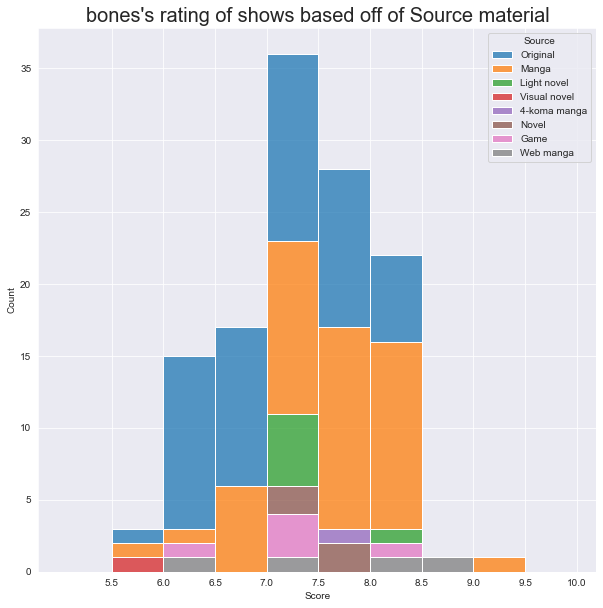

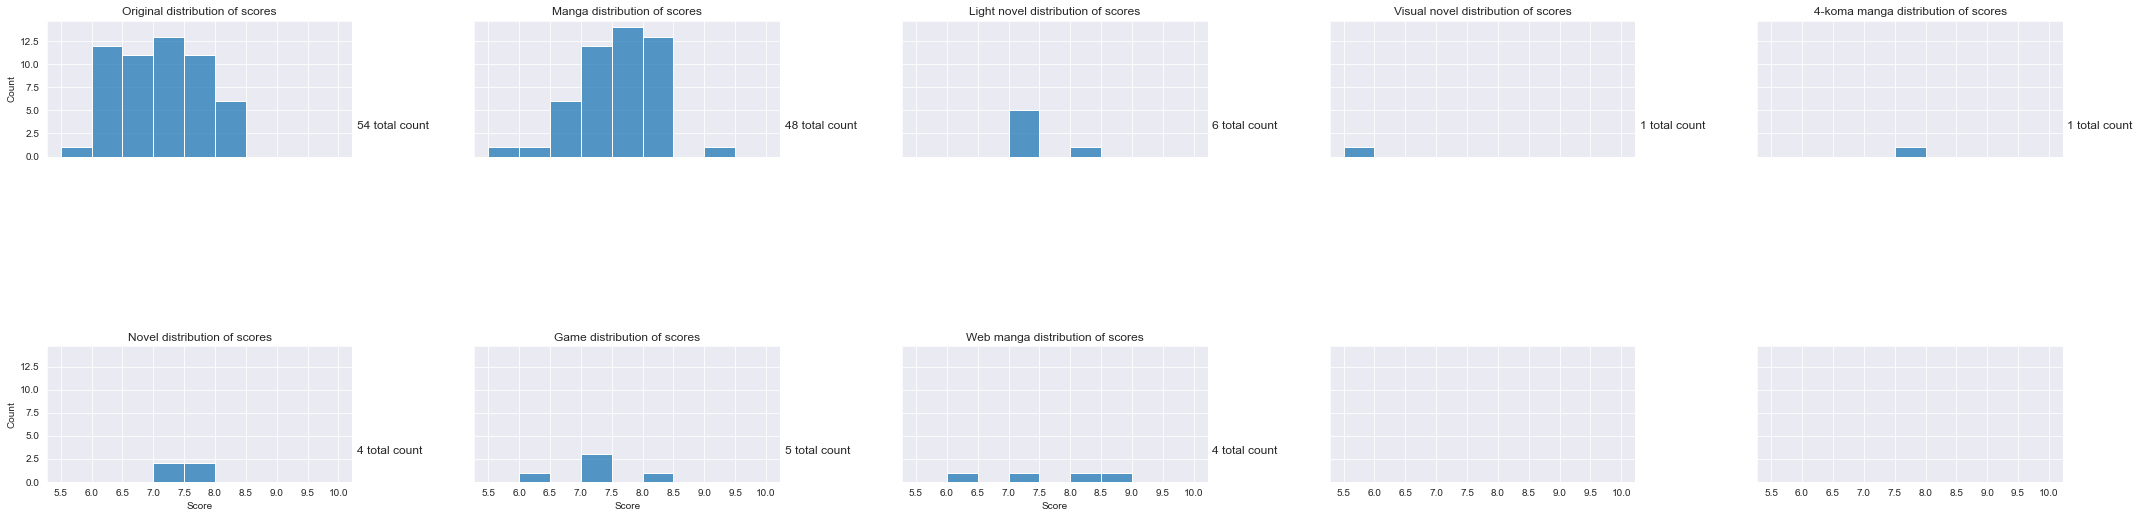

In [518]:
plotStudio(bones, 'bones')

Highly Rated Shows::                                  eng_name  Score
9                                Monster   8.76
239                      Fighting Spirit   8.75
1393                          Death Note   8.63
4050      Fighting Spirit:New Challenger   8.67
4462                             Rainbow   8.52
5156                   The Tatami Galaxy   8.61
6474                     Hunter x Hunter   9.10
10451                      One Punch Man   8.57
13286  A Place Further Than The Universe   8.57
14219                      Chihayafuru 3   8.52


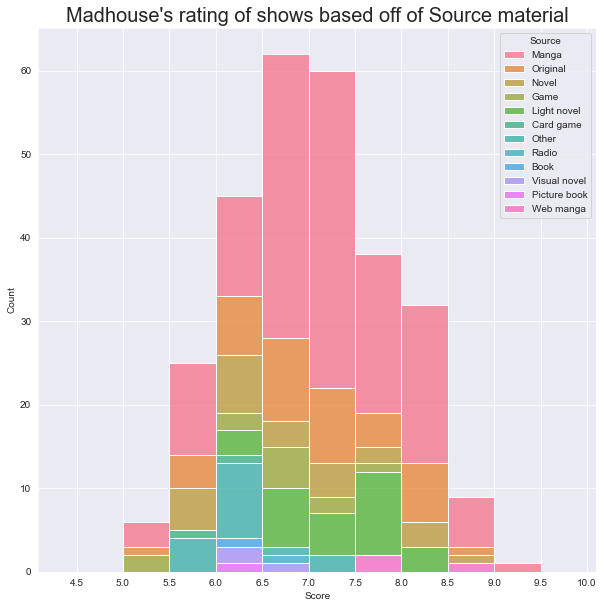

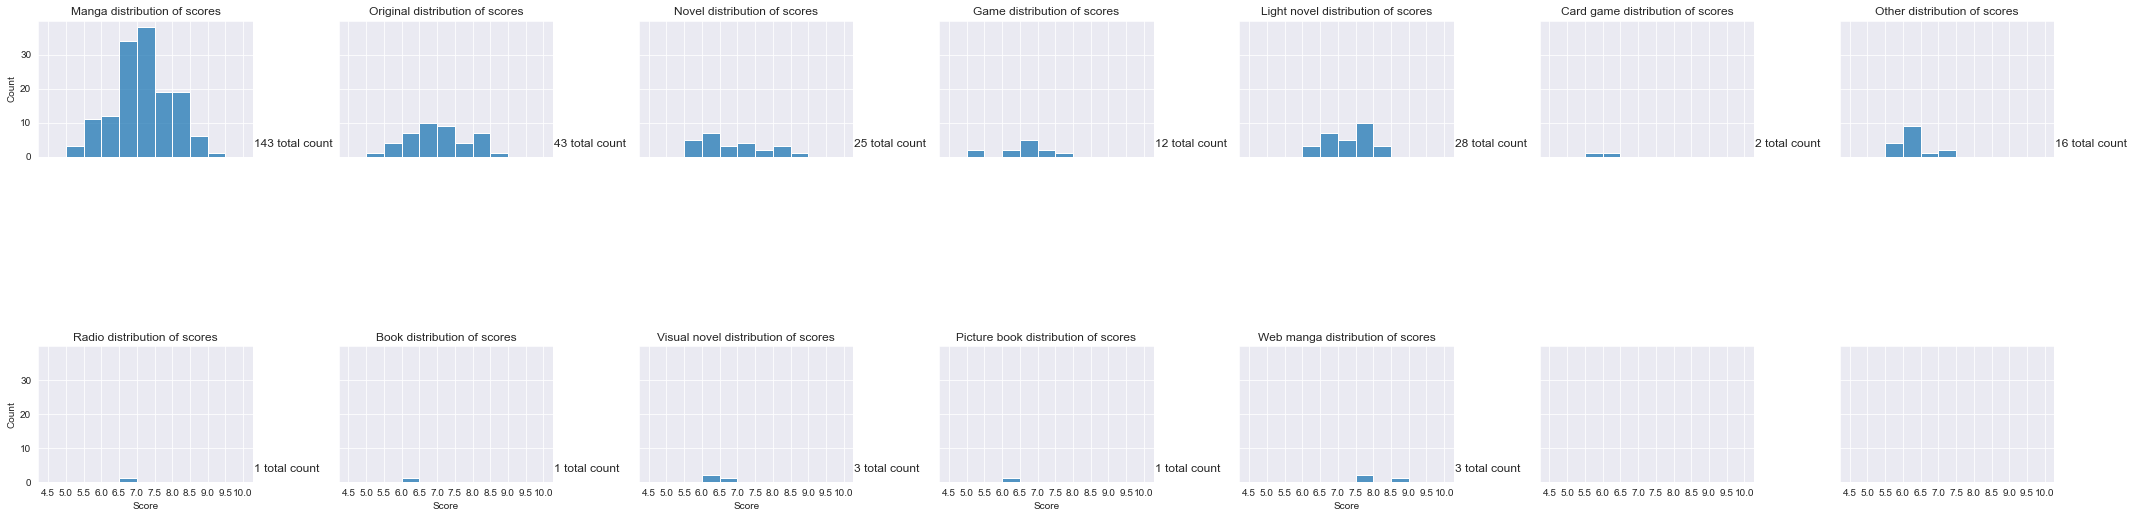

In [519]:
plotStudio(getStudio('Madhouse'), "Madhouse")

Highly Rated Shows::                                                 eng_name  Score
1822                                      Gurren Lagann   8.66
3721  Gurren Lagann The Movie:The Lights in the Sky ...   8.57


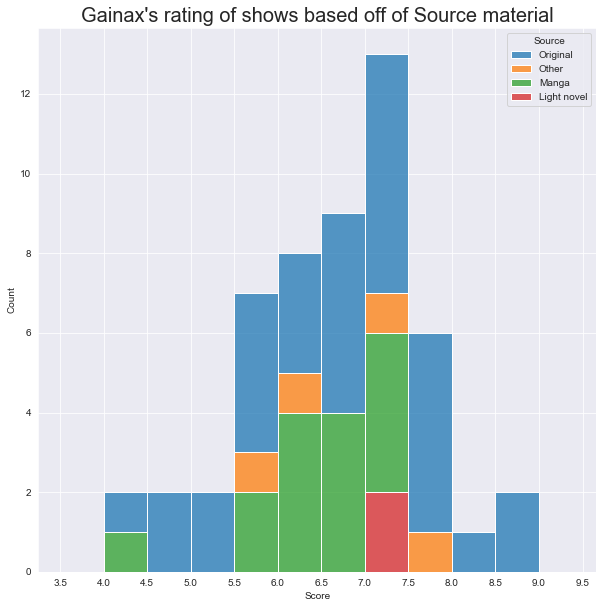

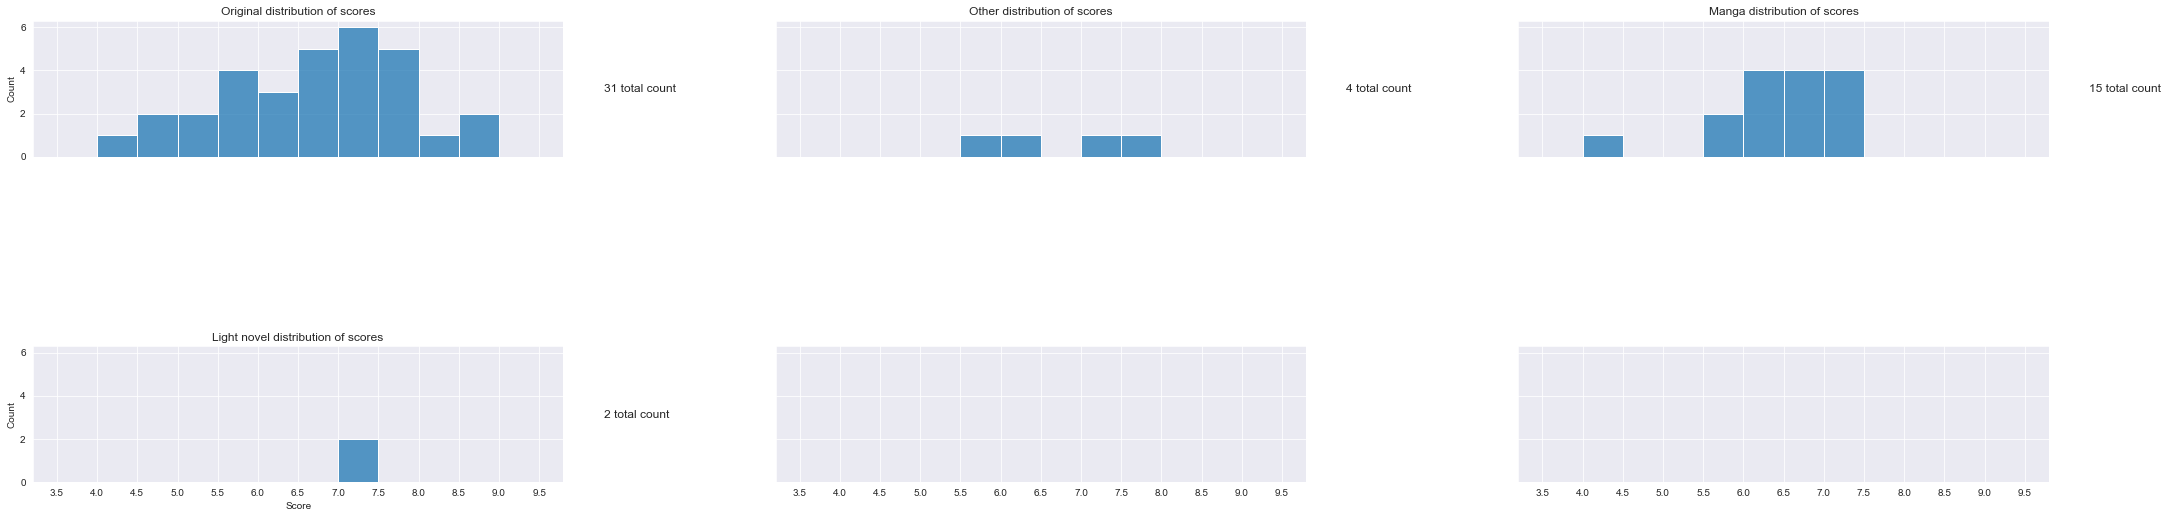

In [520]:
gainax = getStudio('Gainax')
plotStudio(gainax, 'Gainax')

Highly Rated Shows::        eng_name  Score
148  Slam Dunk   8.53


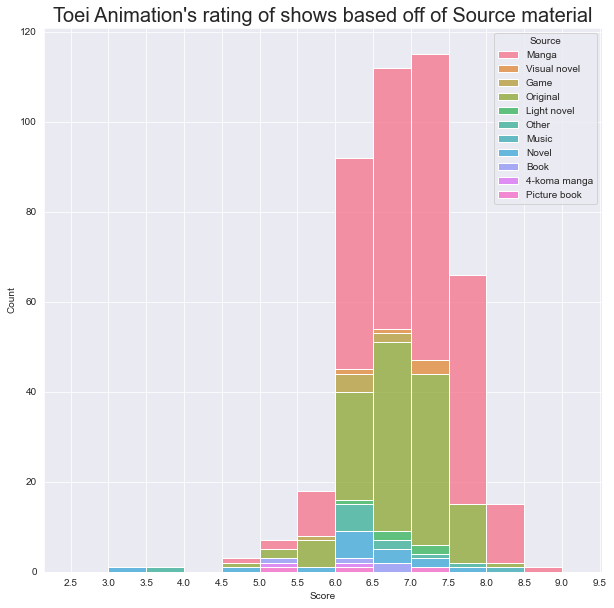

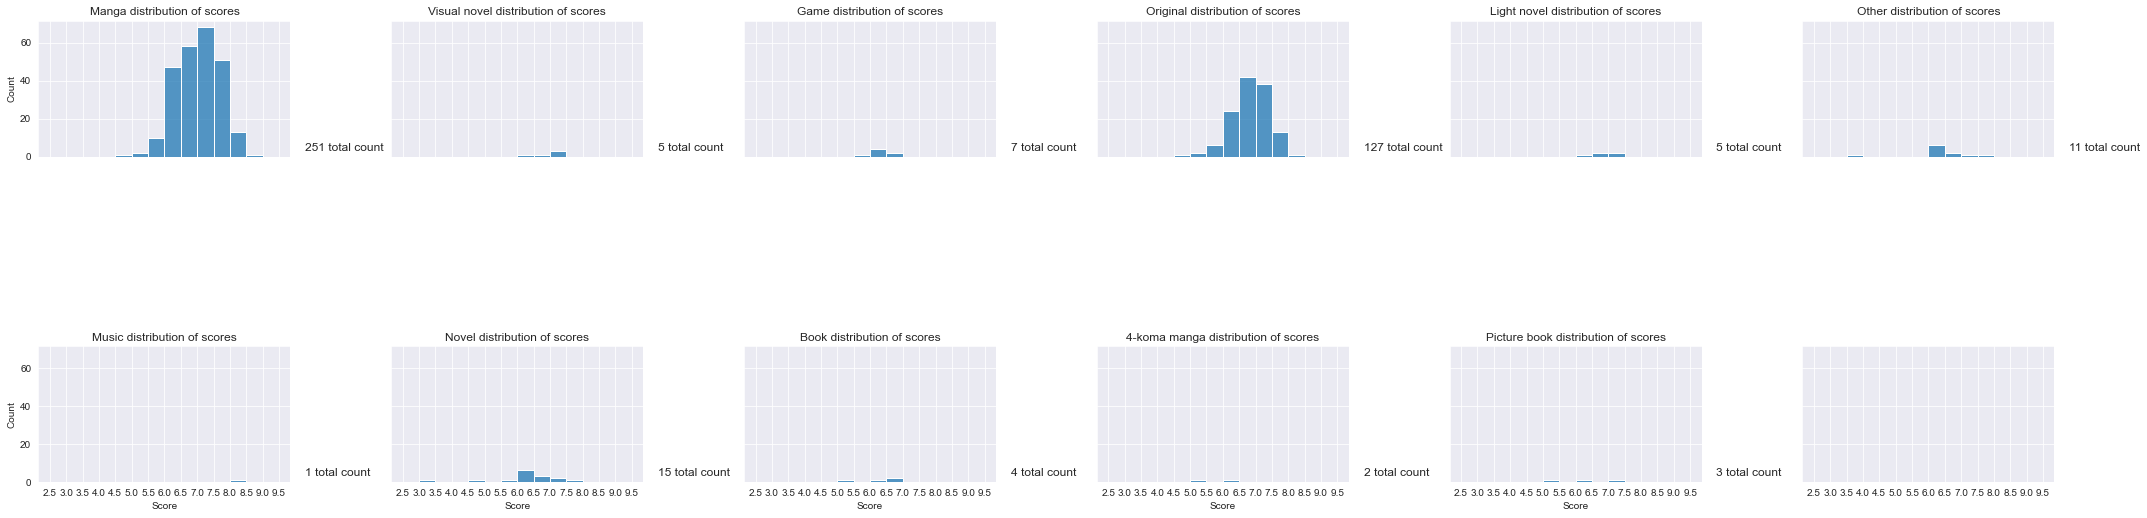

In [521]:
plotStudio(getStudio('Toei Animation'),'Toei Animation')

In [ ]:
g= bones[bones.columns[6:]].columns
s = [bones[x].sum() for x in g ]
summedGenres =  pd.DataFrame(columns=bones[g].columns)
summedGenres.loc[len(summedGenres)] = s

summedGenres
summedGenres.where(lambda x: x > 0)

### Time series of scores over the years

In [29]:
def plotTimeline(studio, separate=False, avg=False, showTopShows=False):
	sb.set_style("darkgrid")
	sb.color_palette("colorblind")
	c = sb.color_palette()
	studio = studio.sort_values("Year")
	if separate:
		fig, ax = plt.subplots(figsize=(20,10), nrows=4, sharex=False, sharey=True)
		i=0
		s = studio[studio.Season == "Summer"]
		sp = studio[studio.Season == "Spring"]
		w = studio[studio.Season == "Winter"]
		f = studio[studio.Season == "Fall"]
		order = np.unique(list(s.Year) + list(w.Year)+ list(sp.Year) + list(f.Year))
		for s in ["Winter",'Summer','Spring','Fall']:
			p=sb.lineplot(data=studio[studio.Season == s], x="Year", y="Score",errorbar=None, ax=ax[i],palette=[c[i]], hue="Season", marker='o')
			p.set_xticks(np.arange(order.min(), order.max(),1))
			i+=1
	if avg:
		fig, ax = plt.subplots(figsize=(20,5))
		temp = studio.groupby("Year").Score.mean()
		size = studio.groupby("Year").size()
		c = sb.color_palette()
		sb.scatterplot(data=temp, x="Year", y=temp.values,palette=['r'], size=size, ax=ax)
		plot = sb.lineplot(data=temp, x="Year", y=temp.values, ax=ax,) 
		plot.set_yticks(np.arange(5,10,1))
	if not avg and not separate:
		fig, ax = plt.subplots(figsize=(20,10))
		sb.lineplot(data=studio, x="Year", y="Score",errorbar=None, palette=c[:4] ,hue="Season",marker='o')
	if showTopShows:
		topYear = studio.groupby("Year").Score.mean().idxmax()
		print("Top shows from the top year {}\n".format(topYear),studio[studio.Year == topYear][["eng_name", "Score","Ranked","Season", "Source"]].sort_values("Score", ascending=False))

# plotTimeline(bones.sort_values(by="Year"),avg=True, showTopShows=True)
# plotTimeline(getStudio('Bones'), separate=False, avg=False, showTopShows=True)

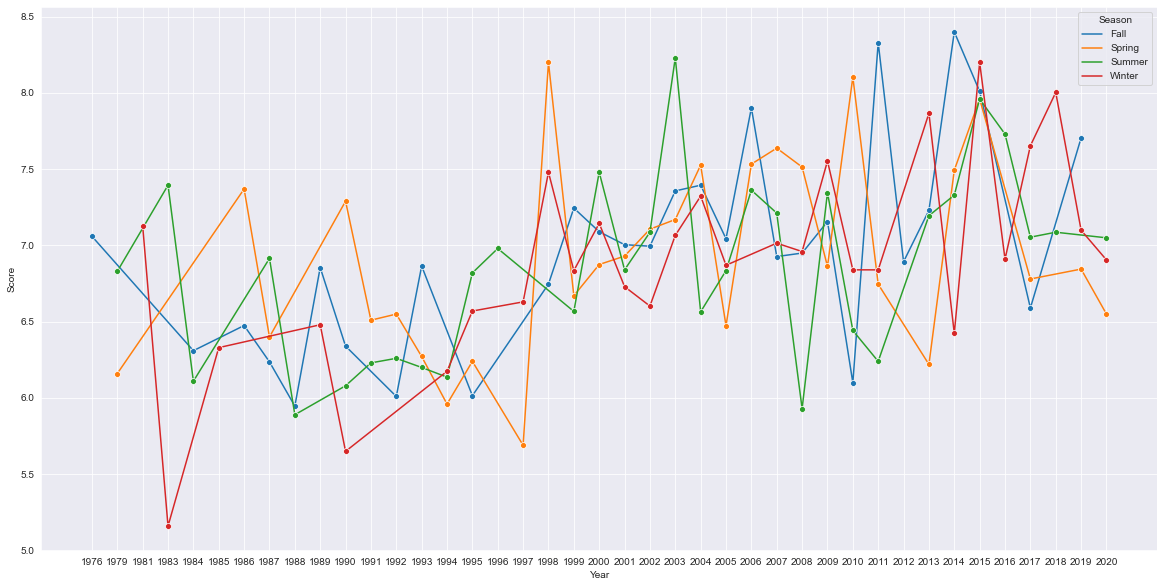

In [95]:
plotTimeline(getStudio('Madhouse'))

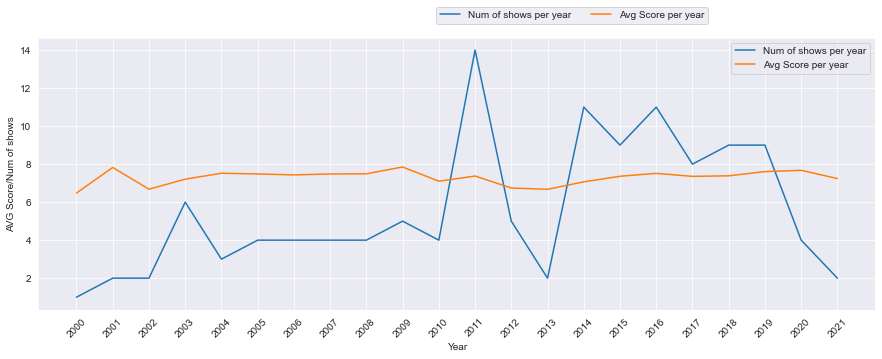

In [114]:
def plotShowsOverTime(studio: pd.DataFrame):
    sb.set_style("darkgrid")
    sb.color_palette("colorblind")
    c = sb.color_palette()
    studio = studio.sort_values("Year")
    years = studio.Year.value_counts()
    years = years.sort_index()
    avgScores = studio.groupby("Year").mean().Score
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_ylabel("AVG Score/Num of shows")
    ax.tick_params(axis='x', rotation=45)
    sb.lineplot(years, label="Num of shows per year")
    sb.lineplot(avgScores, label="Avg Score per year")
    handles, labels = ax.get_legend_handles_labels()
    n = 7  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

    fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(.75, 0.98))

plotShowsOverTime(getStudio('Bones'))

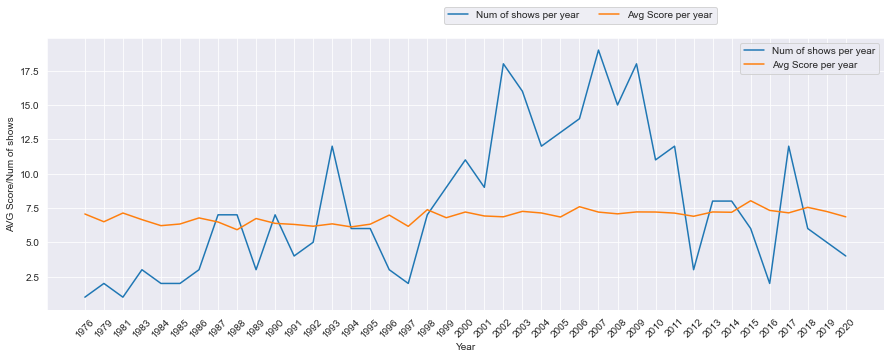

In [115]:
plotShowsOverTime(getStudio('Madhouse'))

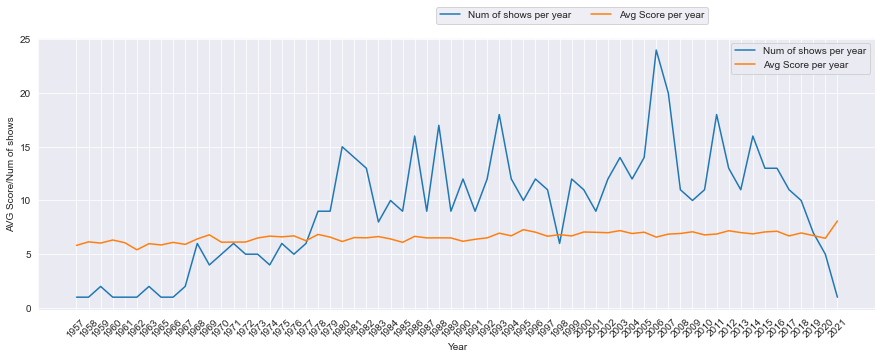

In [116]:
plotShowsOverTime(getStudio('Toei Animation'))